# Comparison of sparsity and selectivity over training in BP, BTSP, and Hebbian networks

## 0. Setup

In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

input_size = 21
dataset = torch.eye(input_size) #each row is a different pattern
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                        shuffle=True, 
                        generator=data_generator)

test_dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                             batch_size = 21)
epochs=300
seed=42

weight_seeds = [65793, 65794, 65795, 65796, 65797] 
data_seeds = [257, 258, 259, 260, 261]

seed = weight_seeds[0]
data_seed = data_seeds[0]

## 1. Create networks

### Dale's Law Backprop (1 inh)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

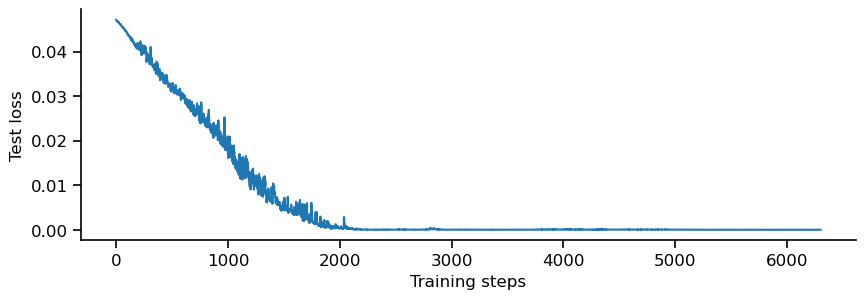

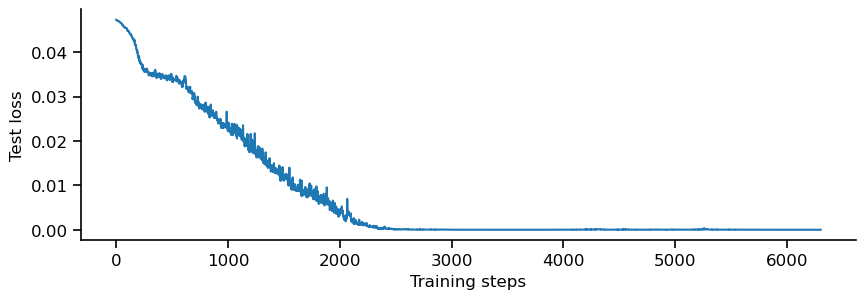

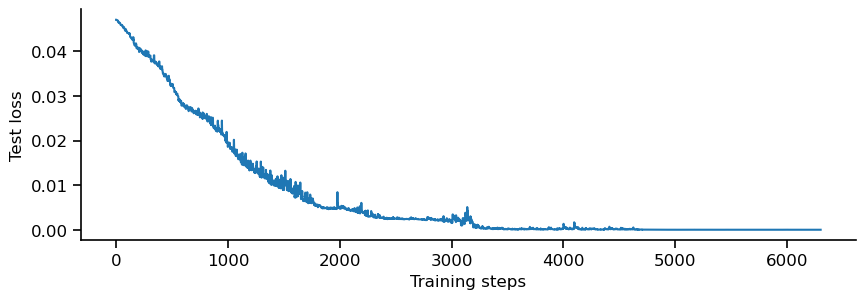

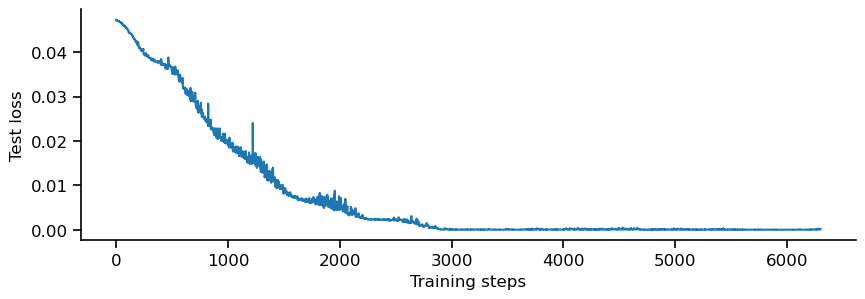

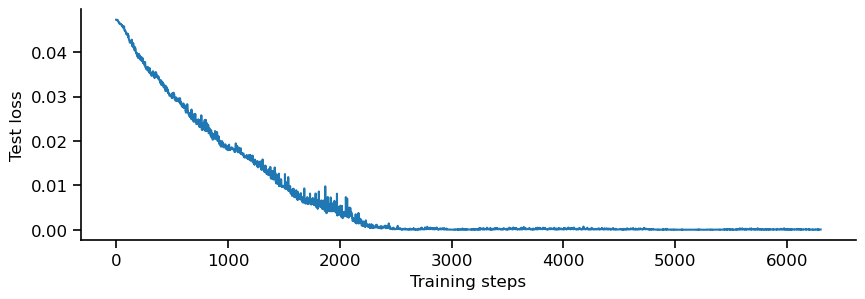

In [2]:
from copy import deepcopy

bpDale_activities = []
bpDale_out_activities = []

for seed,data_seed in zip(weight_seeds,data_seeds):
    network_config = ut.read_from_yaml('../config/loss_landscape_analysis/EIANN_1_hidden_backprop_1_inh_softplus_SGD_config_B.yaml')
    layer_config = network_config['layer_config']
    projection_config = network_config['projection_config']
    training_kwargs = network_config['training_kwargs']

    bpDale_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

    data_generator.manual_seed(data_seed)
    bpDale_network.train(dataloader, epochs, store_history=True, store_params=True, status_bar=True)

    for layer in bpDale_network: #swap to ReLU activation to make loss comparable across networks
        for population in layer:
            population.activation = torch.nn.ReLU()

    bpDale_network.reset_history()
    pt.plot_test_loss_history(bpDale_network, test_dataloader, store_history=True)
    
    bpDale_activities.append(deepcopy(bpDale_network.H1.E.activity_history))
    bpDale_out_activities.append(deepcopy(bpDale_network.Output.E.activity_history))

### BTSP (1 inh)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

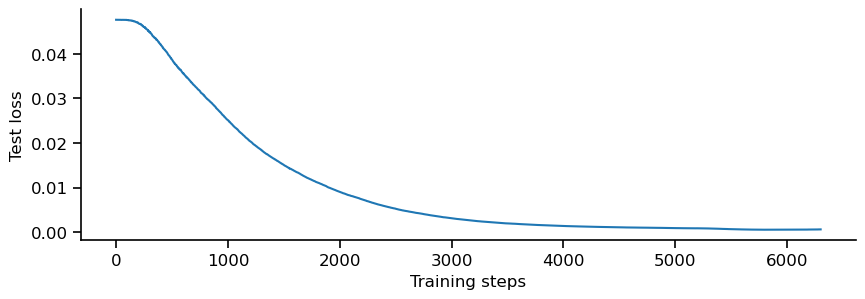

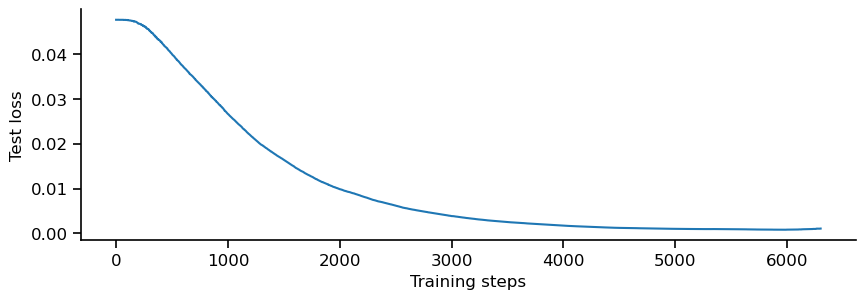

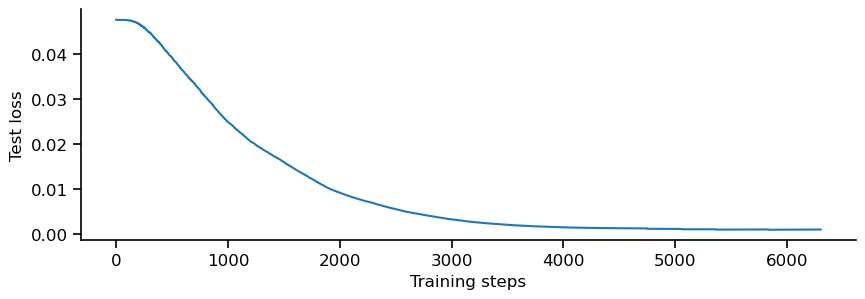

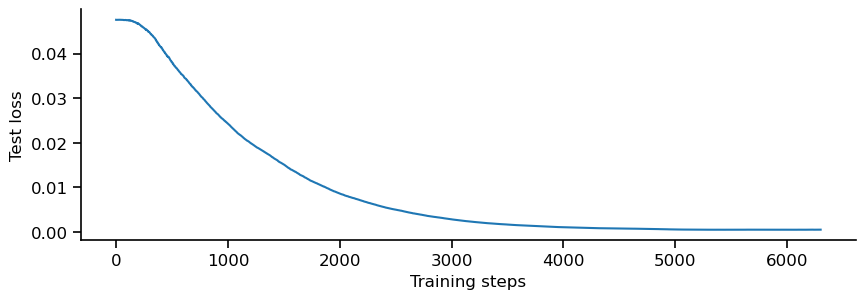

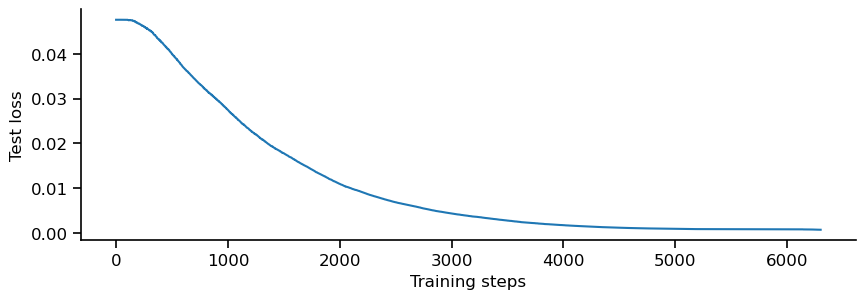

In [3]:
btsp_activities = []
btsp_out_activities = []

for i,(seed,data_seed) in enumerate(zip(weight_seeds,data_seeds)):
#     network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221104_EIANN_1_hidden_BTSP_config_B.yaml')
    network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221107_EIANN_1_hidden_BTSP_config_C.yaml')
    layer_config = network_config['layer_config']
    projection_config = network_config['projection_config']
    training_kwargs = network_config['training_kwargs']

    btsp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

    data_generator.manual_seed(data_seed)
    btsp_network.train(dataloader, epochs, store_history=True, store_params=True, status_bar=True)

    btsp_network.reset_history()
    pt.plot_test_loss_history(btsp_network, test_dataloader, store_history=True)
    
    btsp_activities.append(deepcopy(btsp_network.H1.E.activity_history))
    btsp_out_activities.append(deepcopy(btsp_network.Output.E.activity_history))

## 2. Analyze sparsity & selectivity

In [4]:
from EIANN.plot import *

all_networks = {'bpDale': bpDale_network, 
                'BTSP': btsp_network}

activities_dict = {'bpDale': bpDale_activities,
                   'BTSP': btsp_activities}


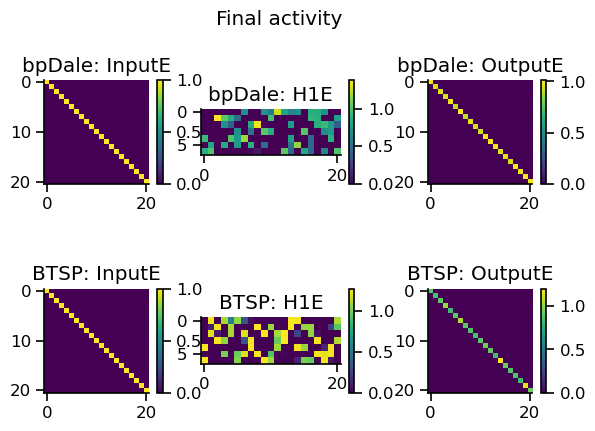

In [5]:
fig = plt.figure(figsize=(6, 10))
axes = gs.GridSpec(nrows=4, ncols=3,
                   left=0.05, right=0.98,
                   top=0.83, bottom=0.1,
                   wspace=0.1, hspace=1)

# i = 0

# for row, model_name in enumerate(activities_dict):
#     populations = [network.Input.E, network.H1.E, network.Output.E]
#     for col, population in enumerate(populations):
#         final_activity = activities_dict[model_name][i][-1,-1].T
#         ax = fig.add_subplot(axes[row, col])
#         im = ax.imshow(final_activity)
#         ax.set_title(f'{name}: {population.fullname}')

for row, (name,network) in enumerate(all_networks.items()):
    populations = [network.Input.E, network.H1.E, network.Output.E]
    for col, population in enumerate(populations):
        final_activity = population.activity_history[-1,-1].T
        ax = fig.add_subplot(axes[row, col])
        im = ax.imshow(final_activity)
        plt.colorbar(im)
        ax.set_title(f'{name}: {population.fullname}')
        
fig.suptitle('Final activity',y=0.9)
plt.show()

fig.savefig('figures/final_activity.svg',dpi=300)
fig.savefig('figures/final_activity.png',dpi=300)

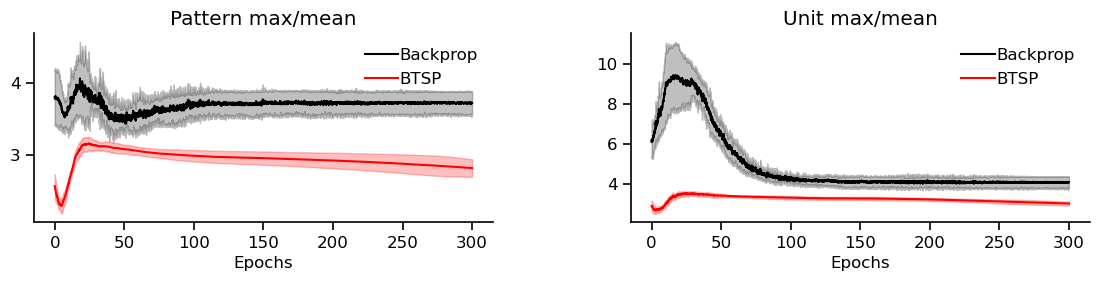

In [17]:
legend_dict = {'bpDale': ('Backprop','k'), 
                'BTSP': ('BTSP','r')}

fig = plt.figure(figsize=(12, 3))
axes = gs.GridSpec(nrows=1, ncols=2,
                   left=0.1, right=0.98,
                   top=0.83, bottom=0.2,
                   wspace=0.3, hspace=1)

ax = fig.add_subplot(axes[0])
for model_name in activities_dict:
    history_len = len(btsp_network.param_history)
    sparsity = torch.zeros(len(data_seeds),history_len)
    for i,activity_history in enumerate(activities_dict[model_name]):
        for t,activity in enumerate(activity_history[:,-1]):
            s = torch.zeros(21)
            for p,pattern in enumerate(activity):
                s[p] = (torch.max(pattern)+1e-10)/(torch.mean(pattern)+1e-10)
            sparsity[i,t] = torch.mean(s) 
            
    mean_sparsity = torch.mean(sparsity,dim=(0))
    std_sparsity =  torch.std(sparsity,dim=(0))
    time = torch.linspace(0,epochs,history_len)
    ax.plot(time,mean_sparsity, label=legend_dict[model_name][0], color=legend_dict[model_name][1])
    ax.fill_between(time, mean_sparsity - std_sparsity, mean_sparsity + std_sparsity,
                    color=legend_dict[model_name][1], alpha=0.25)  
ax.set_xlabel('Epochs')
ax.set_title('Pattern max/mean')
ax.legend()


ax = fig.add_subplot(axes[1])
for model_name in activities_dict:
    history_len = len(btsp_network.param_history)
    sparsity = torch.zeros(len(data_seeds),history_len)
    for i,activity_history in enumerate(activities_dict[model_name]):
        for t,activity in enumerate(activity_history[:,-1]):
            s = torch.zeros(7)
            for u,unit in enumerate(activity.T):
                s[u] = (torch.max(unit)+1e-10)/(torch.mean(unit)+1e-10)
            sparsity[i,t] = torch.mean(s) 
            
    mean_sparsity = torch.mean(sparsity,dim=(0))
    std_sparsity =  torch.std(sparsity,dim=(0))
    time = torch.linspace(0,epochs,history_len)
    ax.plot(time,mean_sparsity, label=legend_dict[model_name][0], color=legend_dict[model_name][1])
    ax.fill_between(time, mean_sparsity - std_sparsity, mean_sparsity + std_sparsity,
                    color=legend_dict[model_name][1], alpha=0.25)  
ax.set_xlabel('Epochs')
ax.set_title('Unit max/mean')
ax.legend()


plt.show()

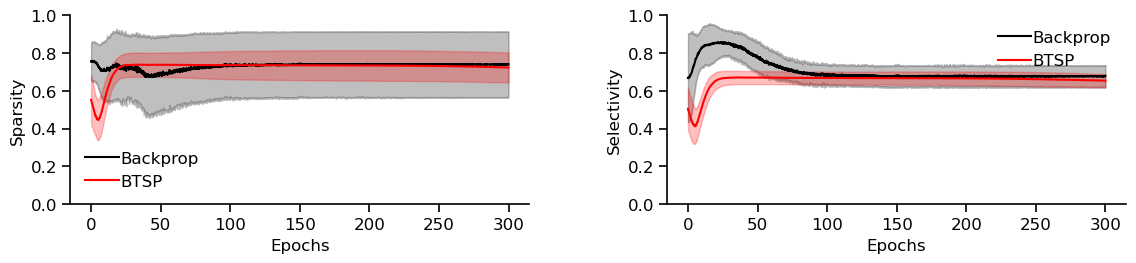

In [18]:
legend_dict = {'bpDale': ('Backprop','k'), 
                'BTSP': ('BTSP','r')}

fig = plt.figure(figsize=(12, 3))
axes = gs.GridSpec(nrows=1, ncols=2,
                   left=0.1, right=0.98,
                   top=0.83, bottom=0.2,
                   wspace=0.3, hspace=1)

ax = fig.add_subplot(axes[0])
for model_name in activities_dict:
    history_len = len(btsp_network.param_history)
    sparsity = torch.zeros(len(data_seeds),history_len,21)
    for i,activity_history in enumerate(activities_dict[model_name]):
        sparsity_history = ut.compute_sparsity_history(activity_history)
        sparsity[i] = sparsity_history[:,-1,:]

    mean_sparsity = torch.mean(sparsity,dim=(0,2))
    std_sparsity =  torch.std(sparsity,dim=(0,2))
    time = torch.linspace(0,epochs,history_len)
    ax.plot(time,mean_sparsity, label=legend_dict[model_name][0], color=legend_dict[model_name][1])
    ax.fill_between(time, mean_sparsity - std_sparsity, mean_sparsity + std_sparsity,
                    color=legend_dict[model_name][1], alpha=0.25)  
ax.set_ylim(bottom=0,top=1)
# ax.set_title('Sparsity during training')
ax.set_xlabel('Epochs')
ax.set_ylabel('Sparsity')
ax.legend()


ax = fig.add_subplot(axes[1])
for model_name in activities_dict:
    history_len = len(btsp_network.param_history)
    selectivity = torch.zeros(len(data_seeds),history_len,7)
    for i,activity_history in enumerate(activities_dict[model_name]):
        selectivity_history = ut.compute_selectivity_history(activity_history)
        selectivity[i] = selectivity_history[:,-1,:]

    mean_selectivity = torch.mean(selectivity,dim=(0,2))
    std_selectivity =  torch.std(selectivity,dim=(0,2))
    time = torch.linspace(0,epochs,history_len)
    ax.plot(time, mean_selectivity, label=legend_dict[model_name][0], color=legend_dict[model_name][1])
    ax.fill_between(time, mean_selectivity - std_selectivity, mean_selectivity + std_selectivity,
                    color=legend_dict[model_name][1], alpha=0.25)  
ax.set_ylim(bottom=0,top=1)
# ax.set_title('Selectivity during training')
ax.set_xlabel('Epochs')
ax.set_ylabel('Selectivity')
ax.legend()

fig.savefig('figures/sparsity_selectivity1.svg',dpi=300)
fig.savefig('figures/sparsity_selectivity1.png',dpi=300)

plt.show()

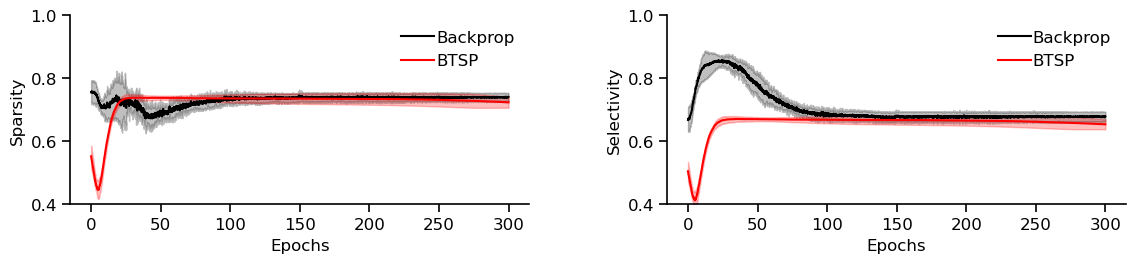

In [19]:
legend_dict = {'bpDale': ('Backprop','k'), 
                'BTSP': ('BTSP','r')}
activities_dict = {'bpDale': bpDale_activities,
                   'BTSP': btsp_activities}

fig = plt.figure(figsize=(12, 3))
axes = gs.GridSpec(nrows=1, ncols=2,
                   left=0.1, right=0.98,
                   top=0.83, bottom=0.2,
                   wspace=0.3, hspace=1)

ax = fig.add_subplot(axes[0])
for model_name in activities_dict:
    history_len = len(btsp_network.param_history)
    sparsity = torch.zeros(len(data_seeds),history_len)
    for i,activity_history in enumerate(activities_dict[model_name]):
        sparsity_history = ut.compute_sparsity_history(activity_history)
        sparsity[i] = torch.mean(sparsity_history[:,-1,:],dim=1)

    mean_sparsity = torch.mean(sparsity,dim=(0))
    std_sparsity =  torch.std(sparsity,dim=(0))
    time = torch.linspace(0,epochs,history_len)
    ax.plot(time,mean_sparsity, label=legend_dict[model_name][0], color=legend_dict[model_name][1])
    ax.fill_between(time, mean_sparsity - std_sparsity, mean_sparsity + std_sparsity,
                    color=legend_dict[model_name][1], alpha=0.25)  
ax.set_ylim(bottom=0.4,top=1)
# ax.set_title('Sparsity during training')
ax.set_xlabel('Epochs')
ax.set_ylabel('Sparsity')
ax.legend()


ax = fig.add_subplot(axes[1])
for model_name in activities_dict:
    history_len = len(btsp_network.param_history)
    selectivity = torch.zeros(len(data_seeds),history_len)
    for i,activity_history in enumerate(activities_dict[model_name]):
        selectivity_history = ut.compute_selectivity_history(activity_history)
        selectivity[i] = torch.mean(selectivity_history[:,-1,:],dim=1)

    mean_selectivity = torch.mean(selectivity,dim=(0))
    std_selectivity =  torch.std(selectivity,dim=(0))
    ax.plot(time,mean_selectivity, label=legend_dict[model_name][0], color=legend_dict[model_name][1])
    ax.fill_between(time, mean_selectivity - std_selectivity, mean_selectivity + std_selectivity,
                    color=legend_dict[model_name][1], alpha=0.25)  
ax.set_ylim(bottom=0.4,top=1)
# ax.set_title('Selectivity during training')
ax.set_xlabel('Epochs')
ax.set_ylabel('Selectivity')

ax.legend()


fig.savefig('figures/sparsity_selectivity2.svg',dpi=300)
fig.savefig('figures/sparsity_selectivity2.png',dpi=300)

plt.show()